# Secular chaos in Kepler 11
Kepler-11 is a remarkable example of a densely packed planetary system with 6 (!) planets. The system seems to be in a regular part of parameterspace, however, a small pertubation of a few percent moves the system into a chaotic regime. This examples reproduces Figure 1 in [Mahajan & Wu 2014](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1409.0011).

Let us first import the necessary packages (this example requires rebound, matplotlib, numpy and scipy).

In [2]:
import rebound
import numpy as np
from io import StringIO
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt

The following orbital parameters of Kepler-11 are those from Mahajan & Wu.

In [32]:
m0 = 0.95 # stellar mass
kep = np.loadtxt(StringIO(u"""
#m/m0  a         e*sinw   e*cosw    I     M
12e-6  0.091110  0.0030   -0.0009   88.5  26.1
36e-6  0.106497  -0.0026  0.0011    89.0  169.6
23e-6  0.154141  -0.0127  0.0148    89.3  350.9
28e-6  0.193972  -0.0161  0.000005  88.8  77.2
10e-6  0.249498  -0.0119  -0.0037   89.4  23.0
28e-6  0.463981  0.       0.        89.8  34.5
"""))

We can now setup the simulation by adding the star and 6 planets.

In [49]:
def setupSim(scale_a2=1.):
    sim = rebound.Simulation()
    sim.add(m=m0) # star
    for i,p in enumerate(kep):
        a = p[1]
        es, ec = p[2], p[3]
        e = np.sqrt(es*es+ec*ec)
        w = np.arctan2(es,ec)
        if i==1: # allow us to perturb the semi-major axis of Kepler-11 c
            a *= scale_a2
        sim.add(m=p[0]*m0,a=a,e=e,omega=w,inc=p[4]/180*np.pi-np.pi/2.,M=p[5]/180*np.pi)
    sim.dt = sim.particles[1].P*0.0512345    # 20 timesteps per orbit
    sim.integrator = "whfast"
    sim.integrator_whfast_safe_mode = 0
    sim.move_to_com()
    return sim
sim = setupSim()

Before performing any integration, let us look at the system top-down:

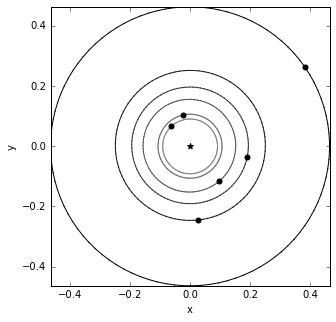

In [50]:
rebound.OrbitPlot(sim);

We now integrate the system forward in time and take measurements of $z = e \cdot \sin(\bar\omega)$, where $e$ and $\bar\omega$ are the eccentricity and longitude of pericenter of the 2nd planet (Kepler-11 c). We take $N=10000$ measurements seperated by $dt=10$yrs.

In [51]:
N = 10000
dt = 1e1 *2*np.pi # 10 years
z = np.zeros(N)
for i in range(N):
    sim.integrate(sim.t+dt)
    z[i] = sim.particles[2].e*np.sin(sim.particles[2].pomega)

Plotting the power spectrum of $z$ gives us an idea of the dominant frequencies in the system. 

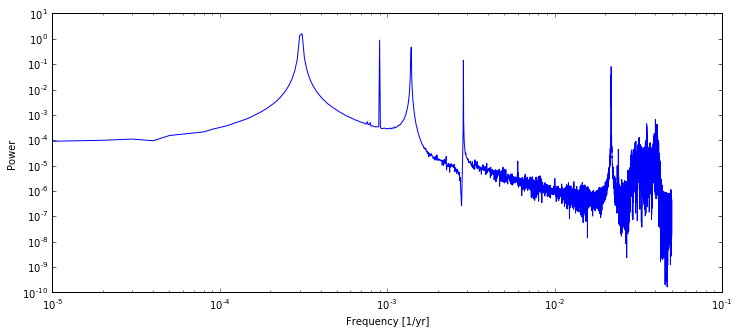

In [52]:
def plot_powerspectrum(timeseries):
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(111)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Frequency [1/yr]")
    ax.set_ylabel("Power")
    for ts in timeseries:
        f, P = signal.periodogram(ts,fs=(2.*np.pi)/dt)
        ax.plot(f[1:],P[1:],"-");
plot_powerspectrum([z])

To decrease the noise of power spectrum at long timescales (and see $g_6$), one needs to increase $N$. Obviously this means an increase in runtime (with $N=10000$ the simulation runs for a few minutes). 

Let us now redo the simulation but slightly vary the initial semi-major axis of planet c by 3%. This moves thes system from a regular to a chaotic part of phase space.

In [46]:
sim = setupSim(1.03)

In [47]:
z_103 = np.zeros(N)
for i in range(N):
    sim.integrate(sim.t+dt)
    z_103[i] = sim.particles[2].e*np.sin(sim.particles[2].pomega)

If we overplot the two power spectra, one can see that they look very different. In the regular chase, the eigenfrequencies of the system are well defined. They are mich more smeared our for the chaotic case. Compare with the second panel of Figure 1 in Mahajan & Wu.

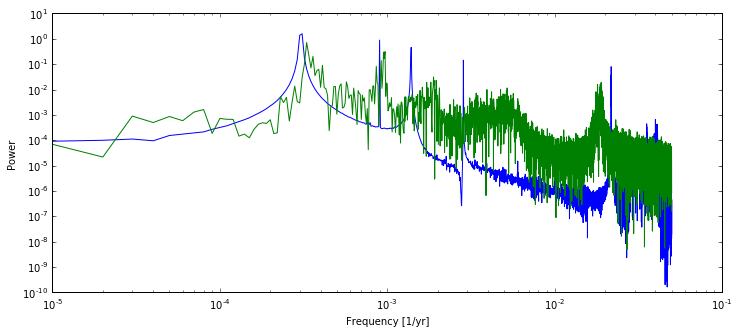

In [53]:
plot_powerspectrum([z,z_103])